In [1]:
import numpy as np
import pandas as pd
import requests
from bs4 import BeautifulSoup
import re

header = {
  "User-Agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.75 Safari/537.36",
  "X-Requested-With": "XMLHttpRequest"
}

In [2]:
# load data from years 83-07
r83 = requests.get("http://web.archive.org/web/20070908142457/http://chronicle.com/stats/usnews/", headers=header)
df83 = pd.read_html(r83.text)[0]

# clean data format
data83 = df83.iloc[3:60,2:24]
cols = df83.iloc[2, 2:16].str.replace("'", "19").append(df83.iloc[2, 16:24].str.replace("'", "20"))
data83.rename(columns=cols.astype(int), index=df83.iloc[3:60, 1], inplace=True)
print(data83.shape)
data83.head()

(57, 22)


,1983,1985,1988,1989,1990,1991,1992,1993,1994,1995,...,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007
Princeton University,4,4,4,2,2,4,4,2,2,2,...,1,1,4,1,1,1,1,1,1,1
Harvard University,2,2,2,4,3,1,1,1,1,1,...,1,1,2,2,2,2,1,1,1,2
Yale University,3,2,3,1,1,3,2,3,3,3,...,3,1,4,2,2,2,3,3,3,3
Stanford University,1,1,1,6,6,2,3,4,6,5,...,5,4,6,6,5,4,5,5,5,4
California Institute of Technology,12,NaN,21,3,4,5,4,5,5,7,...,9,9,1,4,4,4,5,8,7,4


In [3]:
# load data from years 11-18
r11 = requests.get("http://publicuniversityhonors.com/2016/09/18/average-u-s-news-rankings-for-126-universities-2010-1017/", \
                 headers=header)
df11 = pd.read_html(r11.text)[0]

# clean data format
data11 = df11.iloc[3:128,1:9]
data11.rename(columns=df11.iloc[0, 1:9].astype(int), index=df11.iloc[3:128, 0], inplace=True)
print(data11.shape)
data11.head()

(125, 8)


,2011,2012,2013,2014,2015,2016,2017,2018
Princeton,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
Harvard,1.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0
Yale,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0
Columbia,4.0,4.0,4.0,4.0,4.0,4.0,5.0,5.0
Chicago,9.0,5.0,4.0,5.0,4.0,4.0,3.0,3.0


In [4]:
# load data from years 2008-15
r08 = requests.get("http://publicuniversityhonors.com/2015/06/13/u-s-news-national-university-rankings-2008-present/", \
                 headers=header)
df08 = pd.read_html(r08.text)[0]

# clean data format
data08 = df08.iloc[1:126,1:9]
data08.rename(index=df08.iloc[1:128, 0], inplace=True)
print(data08.shape)
data08.head()

(125, 8)


,2008,2009,2010,2011,2012,2013,2014,2015
Princeton,1.0,2.0,1.0,2.0,1.0,1.0,1.0,1.0
Harvard,2.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0
Yale,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0
Stanford,4.0,4.0,4.0,5.0,5.0,6.0,5.0,4.0
Columbia,9.0,8.0,8.0,4.0,4.0,4.0,4.0,4.0


In [5]:
# combine data from 2008 to 2018
data08 = data08.join(data11.iloc[:,5:8], how='left')

# combine data from 1983 with data from 2008

In [2]:
# define functions that cleans university names

def extract(names):
    """ extract meaningful words given the list of names"""
    words = re.sub("[^a-zA-Z&.']", " ", " ".join(names)).strip().split(" ")
    meaningful = [w for w in words if not w in ['University','of','at','in','the','The','and','&']]
    return set(meaningful)-{''}

def abbreviation(name):
    """ get abbreviation of a given name """
    return re.sub("[^A-Z]","", name)

# univset = [extract(x) for x in univs]
# univabb = [abbreviation(x) for x in univs]

# # crearte map from state universities to all universities
# mapState = []
# for univ in stateUnivs:
#     name = univ.split("(")[0].strip()
#     try:
#         index = [univset.index(name)]
#         print("name")
#     except ValueError:
#         index = []
#         for i, s in enumerate(univset):
#             if all([univ.lower().find(x)!=-1 for x in s]):
#                 index.append(i)
#     mapState.append(index)

In [ ]:
# load university names
r = requests.get("http://doors.stanford.edu/~sr/universities.html")

In [5]:
# create university list identified by website domains
locs = [x.start() for x in re.finditer('<li>', r.text)]
locs.append(len(r.text))
univs = {}
for i in range(len(locs)-1):
    s = r.text[locs[i]:locs[i+1]].replace("Ilinois", "Illinois").replace("Univervsity", "University").replace("&amp;","&")
    if s.find('.edu)')==-1:
        continue
    d = s[s.find('(')+1:s.find(')')]
    s = s[s.find('\n'):s.find("</a>")].replace("\n","").replace("\t","").strip()
    if d in univs:
        univs[d].append(s)
    else:
        univs[d] = [s]
univs = list(univs.values())

In [8]:
univs

[['University of Akron'],
 ['Providence College'],
 ['University of Tennessee, Knoxville'],
 ['Bucknell University'],
 ['Washington Bible College/Capital Bible Seminary'],
 ['Fairmont State College'],
 ['St. Lawrence University'],
 ['Drury College'],
 ['College of the Atlantic'],
 ['Furman University'],
 ['American Coastline University'],
 ['Rockhurst College'],
 ['Saint Cloud State University'],
 ['California State University, San Bernardino'],
 ['Medical College of Wisconsin'],
 ['Delta State University'],
 ['University of Central Arkansas'],
 ['Averett College'],
 ['California State University, Los Angeles'],
 ['University of Hawaii at Hilo Physics and Astronomy'],
 ['The Cooper Union for the Advancement of Science and Art'],
 ['Middle Georgia College'],
 ['Stevens Institute of Technology'],
 ['Troy State University'],
 ['Clayton State College'],
 ['Black Hills State University'],
 ['Florida Gulf Coast University'],
 ['Hastings College'],
 ['Carson-Newman College'],
 ['Dickinson Col

In [9]:
# load state universities and flagship campus
r = requests.get("https://en.wikipedia.org/wiki/List_of_state_universities_in_the_United_States")

In [18]:
univstate = []
for line in r.iter_lines(decode_unicode=True):
    if line.find(" - flagship/main campus")!=-1:
        s = BeautifulSoup(line, 'html.parser').get_text().replace(" - flagship/main campus", "").split('(')
        print([s[0].strip(), s[-1].replace(')','')]+[x.strip() for x in s[1].replace(')','').split('or')])

['University of Alabama', 'Tuscaloosa', 'Alabama']
['Auburn University', 'Auburn', 'Auburn']
['Troy University', 'Troy', 'Troy']
['University of Alaska Fairbanks', 'Fairbanks', 'UAF']
['University of Arkansas', 'Fayetteville', 'Arkansas']
['University of Colorado Boulder', 'Boulder', 'Col', 'ado', 'CU']
['Colorado State University', 'Fort Collins', 'Col', 'ado State']
['University of Connecticut', 'Storrs', 'UConn']
['University of Florida', 'Gainesville', 'UF']
['University of Hawaii at Manoa', 'Manoa', 'Hawaii', 'UH']
['University of Illinois at Urbana–Champaign', 'Urbana and Champaign', 'Illinois']
['Southern Illinois University Carbondale', 'Carbondale', 'SIU']
['Indiana University Bloomington', 'Bloomington', 'Indiana', 'IU']
['Purdue University', 'West Lafayette', 'West Lafayette']
['Louisiana State University and A&M College', 'Baton Rouge', 'LSU']
['Southern University', 'Baton Rouge', 'Baton Rouge']
['University of Maryland, College Park', 'College Park', 'Maryland, UMCP,', 'U

In [86]:
stateUnivs

['University of Alabama (Alabama) (Tuscaloosa)',
 'Auburn University (Auburn) (Auburn)',
 'Troy University (Troy) (Troy)',
 'University of Alaska Fairbanks (UAF) (Fairbanks)',
 'University of Arkansas (Arkansas) (Fayetteville)',
 'University of Colorado Boulder (Colorado or CU) (Boulder)',
 'Colorado State University (Colorado State) (Fort Collins)',
 'University of Connecticut (UConn) (Storrs)',
 'University of Florida (UF) (Gainesville)',
 'University of Hawaii at Manoa (Hawaii or UH) (Manoa)',
 'University of Illinois at Urbana–Champaign (Illinois) (Urbana and Champaign)',
 'Southern Illinois University Carbondale (SIU) (Carbondale)',
 'Indiana University Bloomington (Indiana or IU) (Bloomington)',
 'Purdue University (West Lafayette)',
 'Louisiana State University and A&M College (LSU) (Baton Rouge)',
 'Southern University (Baton Rouge)',
 'University of Maryland, College Park (Maryland, UMCP, or UMD) (College Park)',
 'University of Massachusetts Amherst (Massachusetts, UMass, UMa

In [85]:
for edu in univs:
    s = extract(univs[edu])
    print(s)

{'Olaf', 'College', 'Saint'}
{'Cleveland', 'State'}
{'St.', 'Francis', 'College'}
{'Denver'}
{'Tabor', 'College'}
{'Carolina', 'North', 'State'}
{'Louisiana', 'College', 'Centenary'}
{'State', 'Louisiana'}
{'Pennsylvania'}
{'Cities', 'Minnesota', 'Twin'}
{'Coast', 'Gulf', 'Florida'}
{'Saginaw', 'Valley', 'State'}
{'Technology', 'Institute', 'New', 'York'}
{'Ohio', 'Miami'}
{'Columbia'}
{'Birmingham', 'College', 'Southern'}
{'Orleans', 'New'}
{'East', 'State', 'Pennsylvania', 'Stroudsburg'}
{'College', 'Benedictine'}
{'State', 'Western', 'College'}
{'College', 'Oberlin'}
{'Scranton'}
{'Technology', 'Massachusetts', 'Institute'}
{'College', 'Middlebury'}
{'Occidental', 'College'}
{'System', 'Texas'}
{'Champlain', 'College'}
{'Central', 'Arkansas'}
{'Fredonia', 'New', 'State', 'York'}
{'Fontbonne', 'College'}
{'Boston'}
{'Law', 'Mitchell', 'William', 'College'}
{'Rice'}
{'Howard'}
{'Carolina', 'South'}
{'Technology', 'Institute', 'California'}
{'Oregon', 'State', 'College', 'Southern'}
{'

In [2]:
for univ in stateUnivs:
    name = univ.split("(")[0].strip()
    try:
        index = [univset.index(name)]
        print("name")
    except ValueError:
        index = []
        for i, s in enumerate(univset):
            if all([univ.lower().find(x)!=-1 for x in s]):
                index.append(i)
    mapState.append(index)

In [40]:
re.sub("[^a-zA-Z&]", " ", ",aea-der &fd\ ")

' aea der &fd  '

In [51]:
print(stateUnivs[11])
print(univs[706])
print(univs[707])

Southern Illinois University Carbondale (SIU) (Carbondale)
Southern Illinois University
Southern Illinois University-Carbondale


In [43]:
for i, x in enumerate(mapState):
    print(i, x)

0 [805]
1 [39]
2 []
3 [806, 808]
4 [811, 859]
5 [832]
6 [193]
7 [836]
8 [845]
9 [851]
10 [856]
11 [706, 707, 712]
12 [369]
13 [608]
14 [430, 431]
15 [712]
16 [872, 873]
17 [875]
18 [880]
19 [882, 886]
20 [197, 890]
21 [496, 894]
22 [894]
23 [423, 896]
24 [899]
25 [639]
26 [527, 731]
27 [831]
28 [879]
29 [561]
30 [564]
31 [918]
32 [567, 918]
33 [586, 922]
34 [927]
35 [930]
36 [197, 940]
37 [878]
38 [953]
39 [685, 976]
40 [976, 1021]
41 [1039]
42 [983]


In [27]:
def findIndex(univ, verbose=True):
    s = extract(univ)
    b = abbreviation(univ)
    try:
        return univs.index(univ)
    except ValueError:
        pass
    try:
        return univset.index(s)
    except ValueError:
        pass
    try:
        i =  univabb.index(b)
        if verbose: print("Match abbreviation:",univ, "->", univs[i])
        return i
    except ValueError:
        index = []
        for i, name in enumerate(univs):
            if all([name.lower().find(y)!=-1 for y in s]):
                index.append(i)
        if len(index)==1:
            if verbose: print("Found all words (unique match):",univ, "->", univs[index[0]])
            return index[0]
        elif len(index)>1:
            stateIndex = []
            for i, name in enumerate(stateUnivs):
                if all([name.lower().find(y)!=-1 for y in s]):
                    stateIndex.append(i)
            if len(stateIndex)==1:
                city = stateUnivs[stateIndex[0]].split("(")[-1].replace(")","")
                for i in index:
                    if univs[i].find(city)!=-1: 
                        if verbose: print("Found all words (flagship state univ):",univ, "->", univs[i])
                        return i
                print("no matching city:", univ)
                return -1
            else: 
                print("multiple matching (flagship state univ):", univ)
                return -1
        else:
            stateIndex = []
            for i, name in enumerate(stateUnivs):
                if all([name.lower().find(y)!=-1 for y in s]):
                    stateIndex.append(i)
            if len(stateIndex)==1:
                
            print("no matching", univ)
            return -1

data83['UnivCode'] = -1
for univ in data83.index:
#     if univ=="University of Virginia":
#         data83.at[univ, 'UnivCode'] = univs.index('University of Virginia, Charlottesville')
# #         continue
#     if univ=="Washington University in St. Louis":
#         data83.at[univ, 'UnivCode'] = univs.index('Washington University, Saint Louis')
#         continue
#     if univ=="Pennsylvania State University at University Park":
#         data83.at[univ, 'UnivCode'] = univs.index('Pennsylvania State University')
#         continue
#     if univ=="Rutgers University at New Brunswick":
#         data83.at[univ, 'UnivCode'] = univs.index('Rutgers University')
#         continue
    data83.at[univ, 'UnivCode'] = findIndex(univ)

Morgantown
multiple [41]
None Pennsylvania State University at University Park
None Rutgers University at New Brunswick


In [11]:
stateUnivs

['University of Alabama (Alabama) (Tuscaloosa)',
 'Auburn University (Auburn) (Auburn)',
 'Troy University (Troy) (Troy)',
 'University of Alaska Fairbanks (UAF) (Fairbanks)',
 'University of Arkansas (Arkansas) (Fayetteville)',
 'University of Colorado Boulder (Colorado or CU) (Boulder)',
 'Colorado State University (Colorado State) (Fort Collins)',
 'University of Connecticut (UConn) (Storrs)',
 'University of Florida (UF) (Gainesville)',
 'University of Hawaii at Manoa (Hawaii or UH) (Manoa)',
 'University of Illinois at Urbana–Champaign (Illinois) (Urbana and Champaign)',
 'Southern Illinois University Carbondale (SIU) (Carbondale)',
 'Indiana University Bloomington (Indiana or IU) (Bloomington)',
 'Purdue University (West Lafayette)',
 'Louisiana State University and A&M College (LSU) (Baton Rouge)',
 'Southern University (Baton Rouge)',
 'University of Maryland, College Park (Maryland, UMCP, or UMD) (College Park)',
 'University of Massachusetts Amherst (Massachusetts, UMass, UMa

In [35]:
data08['UnivCode'] = -1
for univ in data08.index:
    if univ=="Virginia":
        data08.at[univ, 'UnivCode'] = univs.index('University of Virginia, Charlottesville')
        continue
    if univ=="Michigan":
        data08.at[univ, 'UnivCode'] = univs.index('University of Michigan-Ann Arbor')
        continue
    if univ=="Illinois":
        data08.at[univ, 'UnivCode'] = univs.index('University of Illinois at Urbana-Champaign')
        continue
    if univ=="Maryland":
        data08.at[univ, 'UnivCode'] = univs.index('University of Maryland at College Park')
        continue
    if univ=="Alabama":
        data08.at[univ, 'UnivCode'] = univs.index('University of Alabama at Tuscaloosa')
        continue
    if univ=="Colorado":
        data08.at[univ, 'UnivCode'] = univs.index('University of Colorado at Boulder')
        continue
    if univ=="Missouri":
        data08.at[univ, 'UnivCode'] = univs.index('University of Missouri-Columbia')
        continue
    if univ=="Nebraska":
        data08.at[univ, 'UnivCode'] = univs.index('University of Nebraska, Lincoln')
        continue
    if univ=="Tennessee":
        data08.at[univ, 'UnivCode'] = univs.index('University of Tennessee, Knoxville')
        continue
    if univ=="Arkansas":
        data08.at[univ, 'UnivCode'] = univs.index('University of Arkansas - Fayetteville')
        continue
    if univ=="Indiana":
        data08.at[univ, 'UnivCode'] = univs.index('Indiana University/Purdue University at Columbus')
        continue
    if univ=="North Carolina":
        data08.at[univ, 'UnivCode'] = univs.index('University of North Carolina at Chapel Hill')
        continue
    if univ=="Ohio St":
        data08.at[univ, 'UnivCode'] = univs.index('Ohio State University, Columbus')
        continue
    if univ=="Ohio Univ":
        data08.at[univ, 'UnivCode'] = univs.index('Ohio University, Athens')
        continue
    
    if any([x.isupper() for x in univ.split(" ")]):
        try:
            data08.at[univ, 'UnivCode'] = univabb.index(abbreviation(univ))
        except ValueError:
            print(univ)
    else:
        s = extract(univ.replace("Univ","University").replace("St","State"))
        try:
            data08.at[univ, 'UnivCode'] = univset.index(s)
        except ValueError:
            index = []
            for i,x in enumerate(univs):
                if all([x.find(y)!=-1 for y in univ.split()]):
                    index.append(i)
            if len(index)==1:
                data08.at[univ, 'UnivCode'] = index[0]
            elif len(index)>1:
                data08.at[univ, 'UnivCode'] = min(index, key=lambda x:len(univset[x]))
                print("#", univ, "#", univs[data08.at[univ, 'UnivCode']])
                for x in index:
                    print("-",univs[x])
            else:
                print(univ)

# Penn # University of Pennsylvania
- Bloomsburg University of Pennsylvania
- California University of Pennsylvania
- Clarion University of Pennsylvania
- East Stroudsburg State University of Pennsylvania
- Edinboro University of Pennsylvania
- Haverford College in Pennsylvania
- Indiana University of Pennsylvania
- Kutztown University of Pennsylvania
- Lock Haven University of Pennsylvania
- Mansfield University of Pennsylvania
- Millersville University of Pennsylvania
- Pennsylvania State System of Higher Education
- Pennsylvania State University
- Pennsylvania State University-Schuylkill Campus
- Shippensburg University of Pennsylvania
- Slippery Rock University of Pennsylvania
- University of Pennsylvania
- West Chester University of Pennsylvania
- William Penn College
- York College of Pennsylvania
Caltech
# Dartmouth # Dartmouth College
- Dartmouth College
- University of Massachusetts at Dartmouth
William & Mary
# Penn State # Pennsylvania State University
- East Stroudsburg Sta

In [17]:
min([1,2,3,4,5], key=[1,3,2,5,0])

TypeError: 'list' object is not callable

In [13]:
pd.DataFrame({"pre":data08.index.values, "official": [univs[int(x)] for x in data08['UnivCode']]})

,official,pre
0,Youngstown State University,Princeton
1,Youngstown State University,Harvard
2,Youngstown State University,Yale
3,Youngstown State University,Stanford
4,Youngstown State University,Columbia
5,Massachusetts Institute of Technology,MIT
6,Youngstown State University,Penn
7,Youngstown State University,Chicago
8,Youngstown State University,Caltech
9,Youngstown State University,Duke


In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

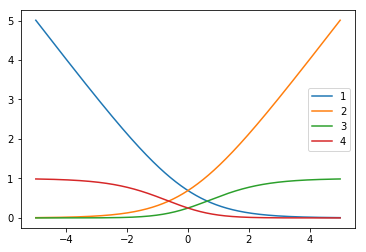

In [5]:
x = np.linspace(-5,5,1000)
plt.figure()
plt.plot(x, np.log(1+np.exp(-x)), label="1")
plt.plot(x, np.log(1+np.exp(x)), label="2")
plt.plot(x, 1./(1+np.exp(-x))**2, label="3")
plt.plot(x, 1./(1+np.exp(x))**2, label="4")
plt.legend(loc='best')
plt.show()

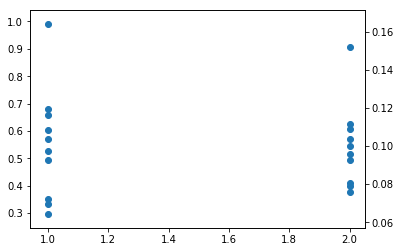

In [10]:
x = np.random.random(10)
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.scatter(np.ones(10), x)
ax2 = ax1.twinx()
ax2.scatter(np.ones(10)*2, np.exp(x)/np.sum(np.exp(x)))
fig.canvas.draw()

In [15]:
x = "before"
x[3]

'o'

In [1]:
import quandl
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import style
import numpy as np
style.use("ggplot")

mydata = quandl.get("EIA/PET_RWTC_D")

from pandas.plotting import lag_plot
from pandas.plotting import autocorrelation_plot

(8009, 1)


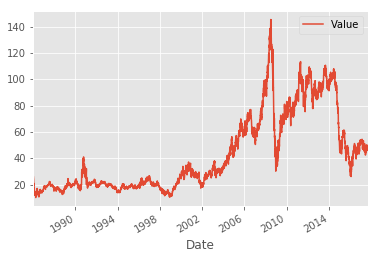

In [21]:
print(mydata.shape)
mydata.plot();

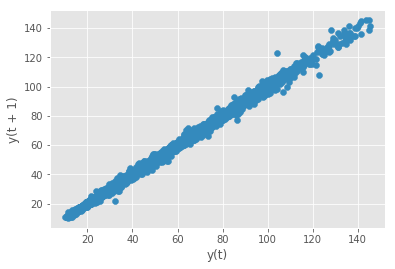

In [22]:
lag_plot(mydata)

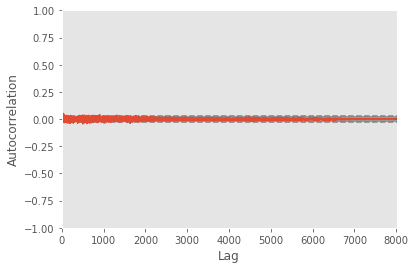

In [26]:
myarray = np.array(mydata)
autocorrelation_plot(myarray[1:,0]-myarray[:-1,0]);

In [13]:
mydata.head()

,Value
Date,
1986-01-02,25.56
1986-01-03,26.00
1986-01-06,26.53
1986-01-07,25.85
1986-01-08,25.87


In [3]:
wn = np.random.normal(0,1,1000)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:15: FutureWarning: pd.ewm_mean is deprecated for ndarrays and will be removed in a future version
  from ipykernel import kernelapp as app


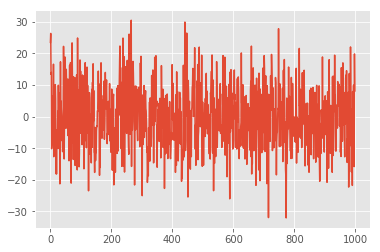

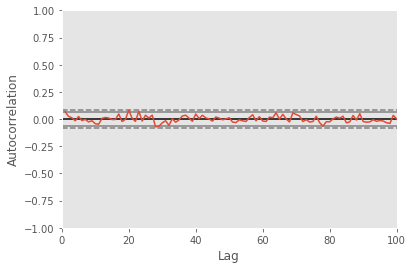

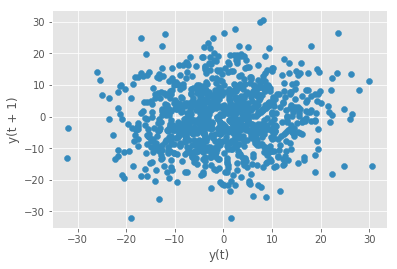

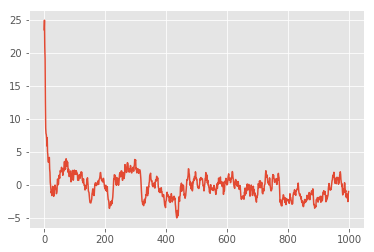

In [9]:
# MA(1)
theta = 10
x = wn[1:]+theta*wn[:-1]
plt.figure()
plt.plot(x,'-')

plt.figure()
autocorrelation_plot(x)
plt.xlim([0,100])

plt.figure()
lag_plot(pd.Series(x))

plt.figure()
plt.plot(pd.ewma(x, 20))

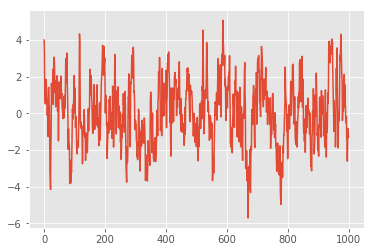

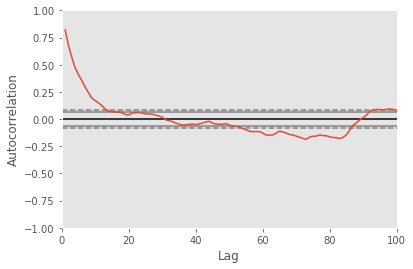

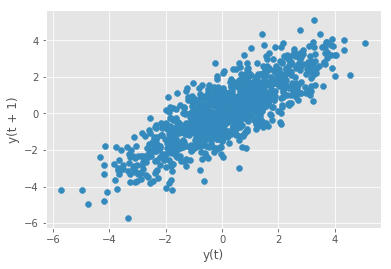

In [10]:
# AR(1)
phi = 0.8
x = [4]
for w in wn:
    x.append(x[-1]*phi+w)
x = np.array(x)

plt.figure()
plt.plot(x,'-')

plt.figure()
autocorrelation_plot(x)
plt.xlim([0,100])

plt.figure()
lag_plot(pd.Series(x))